In [1]:
# Import torch, torchvision and other libraries
import torch
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt

In [35]:
from matplotlib.animation import FuncAnimation, PillowWriter
from functools import partial

In [66]:
np.cos(np.pi/4), -np.sin(np.pi/4), np.sin(np.pi/4), np.cos(np.pi/4)

(0.7071067811865476,
 -0.7071067811865475,
 0.7071067811865475,
 0.7071067811865476)

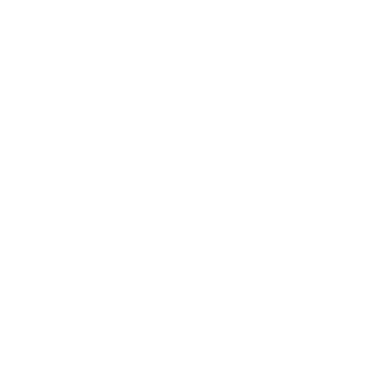

In [49]:
g = 9.81  # Acceleration due to gravity (m/s^2)
l = 1.0   # Length of the pendulum (m)
theta = np.pi / 4  # Initial angle (radians)
omega = 0.0        # Initial angular velocity (rad/s)
dt = 0.05          # Time step (s)

# Initialize figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-1.2 * l, 1.2 * l)
ax.set_ylim(-1.2 * l, 1.2 * l)
ax.set_aspect('equal')
ax.axis('off')

# Create a line to represent the pendulum
line, = ax.plot([], [], lw=2)

# Function to initialize the animation
def init():
    line.set_data([], [])
    return line,

# Parameters for the Gaussian sampling
N = 100  # Number of points to sample per frame
sigma = 0.2  # Standard deviation of the Gaussian noise

# Initialize the data matrix
num_frames = 200
data_matrix = np.zeros((N, num_frames, 2))

# Function to update the animation and generate sampled points
def update_with_sampling(frame):
    global theta, omega
    alpha = -g / l * np.sin(theta)  # Angular acceleration
    omega += alpha * dt            # Update angular velocity
    theta += omega * dt            # Update angle

    # Calculate pendulum position
    x = l * np.sin(theta)
    y = -l * np.cos(theta)
    line.set_data([0, x], [0, y])

    # Sample N points around the pendulum position
    lengths = np.random.uniform(0, l, size=N)  # Random distances along the string
    angles = np.random.normal(loc=theta, scale=sigma, size=N)  # Small angular deviations
    sampled_x = lengths * np.sin(angles)
    sampled_y = -lengths * np.cos(angles)
    sampled_points = np.stack((sampled_x, sampled_y), axis=1)
    data_matrix[:, frame, :] = sampled_points

    return line,

lengths = np.random.uniform(0, l, size=N)  # Random distances along the string
angles = np.random.normal(loc=theta, scale=sigma, size=N)  # Small angular deviations
angle_matrix = np.zeros((N, num_frames))
angle_matrix[:, 0] = angles

def update_with_single_sampling(frame):
    global theta, omega
    alpha = -g / l * np.sin(theta)  # Angular acceleration
    omega += alpha * dt            # Update angular velocity
    theta += omega * dt            # Update angle

    # Calculate pendulum position
    x = l * np.sin(theta)
    y = -l * np.cos(theta)
    line.set_data([0, x], [0, y])

    # Evolve the angle_matrix
    if frame > 0:
        prev_angle = angle_matrix[:, frame - 1]
        new_angle = prev_angle + omega * dt
        angle_matrix[:, frame] = new_angle
        # if frame % 10 == 0:
        #     print(f'Frame {frame}: {new_angle[:5]}')

    return line,

# Create the animation
# update_fn = partial(update_with_single_sampling, theta=theta, omega=omega, angle_matrix=angle_matrix)
ani = FuncAnimation(fig, update_with_single_sampling, frames=range(num_frames), init_func=init, blit=False, interval=dt * 1000)


plt.show()
ani.save('pendulum.gif', writer='pillow', fps=20)
np.save('pendulum.npy', data_matrix)

In [50]:
# Use angle_matrix to get data_matrix
for i in range(num_frames):
    x = lengths * np.sin(angle_matrix[:, i])
    y = -lengths * np.cos(angle_matrix[:, i])
    if i < 5:
        print(f'Frame {i}: {x[:5]}')
    data_matrix[:, i, :] = np.stack((x, y), axis=1)

np.save('pendulum.npy', data_matrix)
print('Saved pendulum.npy')

Frame 0: [0.51684433 0.59965622 0.25734032 0.16160817 0.32203622]
Frame 1: [0.49176904 0.5802734  0.24964396 0.15816893 0.31192502]
Frame 2: [0.45366116 0.55038364 0.237734   0.15274595 0.29631286]
Frame 3: [0.40220009 0.50926582 0.2212786  0.14508071 0.27480175]
Frame 4: [0.3373765  0.45636267 0.20000363 0.13492261 0.24707562]
Saved pendulum.npy


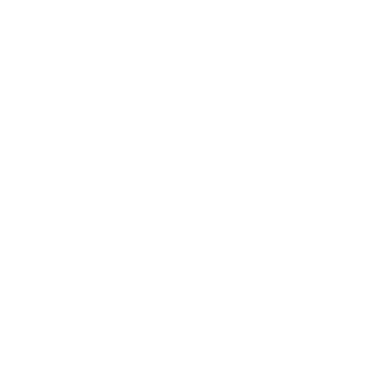

In [ ]:
# Load the data matrix and visualize the sampled points
data_matrix = np.load('pendulum.npy')
fig, ax = plt.subplots()
ax.set_xlim(-1.2 * l, 1.2 * l)
ax.set_ylim(-1.2 * l, 1.2 * l)
ax.set_aspect('equal')
ax.axis('off')

# Create a scatter plot to visualize the sampled points
scat = ax.scatter([], [], s=2)

# Function to initialize the animation
def init(): 
    return scat,

# Function to update the animation
def update(frame):
    scat.set_offsets(data_matrix[:, frame, :])
    return scat,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(num_frames), init_func=init, blit=False, interval=dt * 1000)
plt.show()
ani.save('pendulum_sampling.gif', writer='pillow', fps=20)


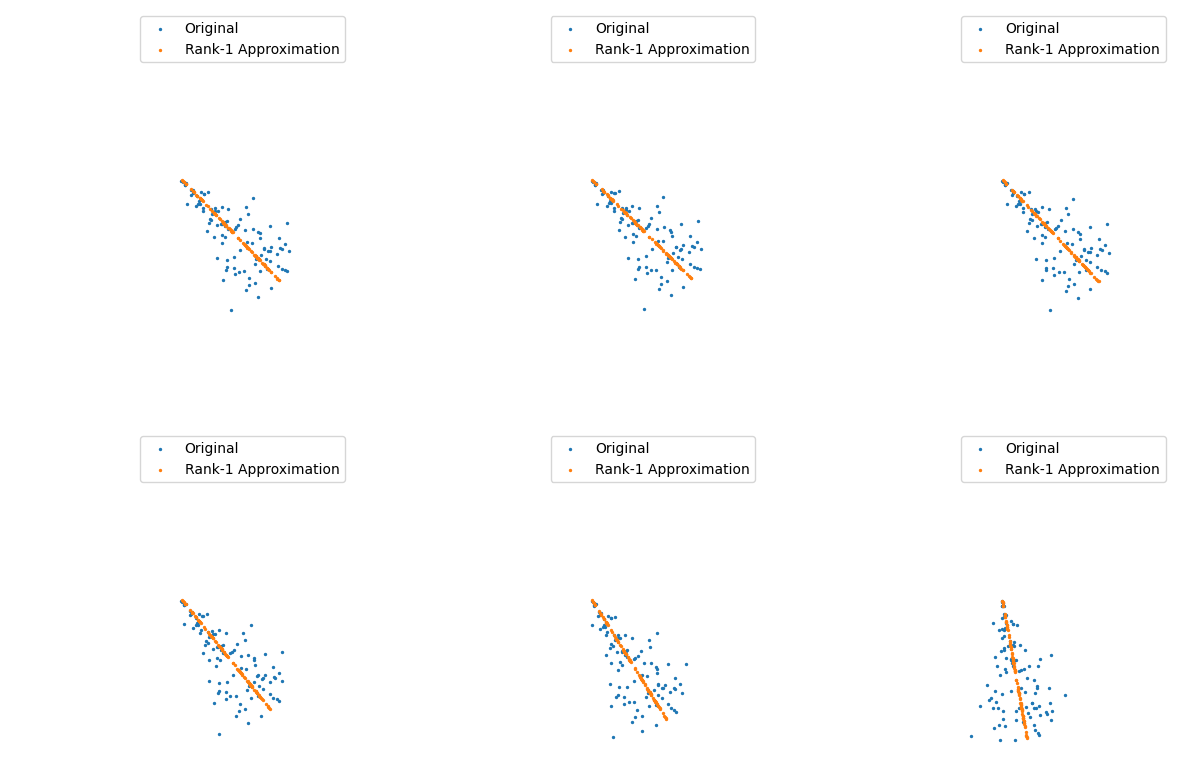

In [53]:
# Compute pointwise pca of data_matrix at each frame
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
rank1_approximations = np.zeros((N, num_frames, 2))
for i in range(num_frames):
    frame_data = data_matrix[:, i, :]
    pca.fit(frame_data)
    rank1_approximations[:, i, :] = pca.mean_ + pca.components_[0] * pca.transform(frame_data)

frame_to_display = [0, 0.2, 0.4, 0.6, 0.8, 0.99]
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, frame in enumerate(frame_to_display):
    ax = axs[i // 3, i % 3]
    ax.set_xlim(-1.2 * l, 1.2 * l)
    ax.set_ylim(-1.2 * l, 1.2 * l)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.scatter(data_matrix[:, int(frame * num_frames), 0], data_matrix[:, int(frame * num_frames), 1], s=2, label='Original')
    ax.scatter(rank1_approximations[:, int(frame * num_frames), 0], rank1_approximations[:, int(frame * num_frames), 1], s=2, label='Rank-1 Approximation')
    ax.legend()

plt.show()
# ani.save('pendulum_sampling.gif', writer='pillow', fps=20)
# np.save('pendulum_rank1_approx.npy', rank1_approximations)
# print('Saved pendulum_rank1_approx.npy')

In [ ]:
print(pca.components_)
last_data = data_matrix[:, -1, :]
l_data_cen = last_data - np.mean(last_data, axis=0)
# SVD
U, S, V = np.linalg.svd(l_data_cen, full_matrices=False)
print(U.shape, S.shape, V.shape)
print(V)
# Rank-1 svd
U1 = U[:, 0]
S1 = S[0]
V1 = V[0, :]

[[-0.28438259  0.95871088]]
(100, 2) (2,) (2, 2)
[[-0.28438259  0.95871088]
 [-0.95871088 -0.28438259]]
(100, 2)


In [ ]:
finite_diff_data = np.diff(data_matrix, axis=1)
def dynamic_low_rank_approx(U, S, V, tau=0.05):
    # U: N x r
    # S: r
    # V: r x 2
    U_arr, S_arr, V_arr = [U], [S], [V]
    for i in range(num_frames):
        K = U_arr[-1] @ S_arr[-1] # N x r
        K_grad = finite_diff_data[:, i, :] @ V_arr[-1].T # N x r
        K = K + tau * K_grad

        L = V.T @ S # 2 x r
        L_grad = U_arr[-1].T @ finite_diff_data[:, i, :] 
        L = L + tau * L_grad

        U_new, _ = np.linalg.qr(K)
        V_new, _ = np.linalg.qr(L.T)
        M = U_new.T @ U_arr[-1]
        U_arr.append(U_new)
        N = V_new.T @ V_arr[-1]
        V_arr.append(V_new)

        tilde_S = M @ S_arr[-1] @ N
        S_grad = U_new.T @ finite_diff_data[:, i, :] @ V_new
        S_new = S_arr[-1] + tau * S_grad
        S_arr.append(S_new)

    return U_arr, S_arr, V_arr